In [1]:
%matplotlib inline
import pandas as pd
from db_scripts.get_server_data import data_dir, get_table_for_variable, fig_dir, get_table_for_variable
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection
from operator import add
import matplotlib
from mpl_toolkits.mplot3d import Axes3D



Read in the data

In [2]:
df = pd.read_csv("{}reformat_by_event.csv".format(data_dir))
df.sort_values('flooded', inplace=True)

In [3]:
df[(df.rain_daily_sum<0.1) & (df.flooded)]

,rain_daily_sum,rain_hourly_max,rain_15_min_max,rain_prev_3_days,gw_elev_avg,tide_elev_avg,num_flooded,flooded,event_name,event_date
13,0.000,1.084202e-15,0.00,2.750000e-02,2.448416,0.826125,1.0,True,unnamed,2015-09-17
22,0.005,1.000000e-02,0.01,1.585000e+00,3.117073,-0.058333,1.0,True,unnamed,2016-07-20
23,0.000,1.405126e-15,0.00,-1.216909e-15,3.149425,0.104667,1.0,True,Bernie Training,2016-07-25


I feel comfortable taking out 2.5 events (I am counting 'Bernie Training' as 0.5 of an event because it says 'Training') filtering on a daily rainfall of above 0.1 inches.

In [4]:
print len(df)
df = df[df.rain_daily_sum > 0.1]
print len(df)

2471
517


let's separate the features out

In [5]:
feat_df = df.iloc[:, :6]
feat_df.head()

,rain_daily_sum,rain_hourly_max,rain_15_min_max,rain_prev_3_days,gw_elev_avg,tide_elev_avg
1235,1.320000,0.32,0.12,1.345000,2.441582,0.064875
1647,0.150000,0.22,0.13,0.993333,1.780793,0.531583
1641,0.333333,0.44,0.34,1.500000,1.781762,0.672500
1640,1.160000,1.18,0.97,1.166667,1.730518,0.718458
1625,0.370000,0.28,0.12,0.370000,2.017969,0.254292


When I tried to do PCA it threw an error saying that my data contained NAN. So here's what I found:

In [6]:
n = feat_df.isnull().any(axis=1)
print sum(n)
feat_df[n]

16


,rain_daily_sum,rain_hourly_max,rain_15_min_max,rain_prev_3_days,gw_elev_avg,tide_elev_avg
614,2.105,1.15,0.45,2.105,NaN,0.083625
626,0.415,0.53,0.35,0.415,NaN,-0.138917
273,0.235,0.07,0.03,0.235,NaN,1.250792
282,0.235,0.06,0.05,0.235,NaN,0.489250
257,1.175,1.28,0.78,1.175,NaN,0.071500
258,0.150,0.14,0.06,1.325,NaN,0.251417
261,0.600,0.35,0.24,0.600,NaN,0.413375
296,0.235,0.17,0.07,0.235,NaN,0.139083
297,2.020,0.61,0.39,2.255,NaN,0.454542
298,0.490,0.34,0.29,2.745,NaN,0.478750


There is a bunch of shallow well depth data missing. Here's some more investigation:

3845
60120
0.0639554224884


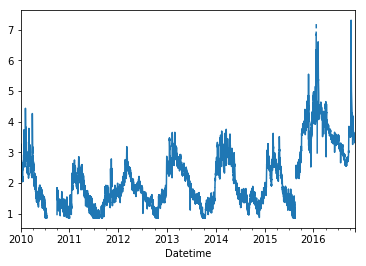

In [7]:
gw_df = get_table_for_variable('groundwater')
gw_df['Value'].plot()
print sum(gw_df['Value'].isnull())
print len(gw_df)
print 3845./60120

So approximately 6% of the gw data is NaN and from the figure a lot of that lookds like it happens at once like for a few months about 2/3 through 2010. I guess we just drop those ones.

In [8]:
df_filt = df[df['gw_elev_avg'].isnull()!= True]
df_filt.reset_index(inplace=True)
feat_df = df_filt.iloc[:, 1:7]

In [9]:
pca = PCA()

In [10]:
p = pca.fit(feat_df)
p.explained_variance_ratio_

array([ 0.55215018,  0.2463997 ,  0.0847108 ,  0.06809952,  0.04622979,
        0.00241002])

In [11]:
p_vis = pca.fit_transform(feat_df)
df_pca = pd.DataFrame(p_vis)
df_filt[df_filt.flooded].index.min()

476

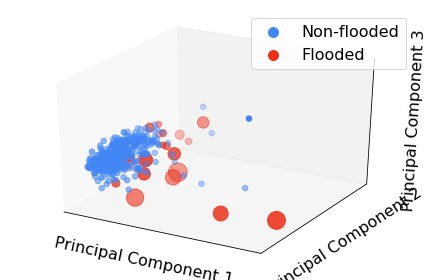

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
nfl = ax.scatter(df_pca.loc[:476,0], df_pca.loc[:476, 1], df_pca.loc[:476, 2], c='#4286f4', label='Non-flooded', s=30)
fl = ax.scatter(df_pca.loc[476:,0], df_pca.loc[476:, 1], df_pca.loc[476:, 2], c='#ed2f1a', s=30+df_filt.loc[476:, 'num_flooded']*6, label='Flooded')
ax.set_ylabel('Principal Component 2', fontsize=16)
ax.set_xlabel('Principal Component 1',  fontsize=16)
ax.set_zlabel('Principal Component 3',  fontsize=16)
ax.set_xticks(())
ax.set_zticks(())
ax.set_yticks(())
ax.tick_params(labelsize=16)
legend = ax.legend(fontsize=16, handler_map={fl: HandlerPathCollection(sizes=[100]), nfl: HandlerPathCollection(sizes=[100])})
fig.tight_layout()
fig.savefig('{}pc.png'.format(fig_dir), dpi=300)

I'm interested in the non-flooding points that are far away from the rest of the group.

In [13]:
high_pc1 = df_pca[df_pca[0]>8].index
high_pc1

Int64Index([48, 163, 485, 500], dtype='int64')

In [14]:
def plot_features(record_indicies, df):
    ax = df.iloc[record_indicies, [1, 2, 3, 4, 5, 6]].plot.bar(fontsize=14, rot=15, legend=False, figsize=(7, 5.5))
    patches, labels = ax.get_legend_handles_labels()
    label_units = ([' (in)', ' (in)', ' (in)', ' (in)', ' (ft)', ' (ft)'])
    labels = map(add, labels, label_units)
    ax.legend(patches, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=14)
    print df.loc[record_indicies]
    ax.set_xticklabels(
        df.loc[record_indicies, 'event_name']+"\n"+ "(" +  df.loc[record_indicies, 'num_flooded'].astype(str)+")"
    )
    ax.set_xlabel('Event name \n (# locations flooded)', fontsize=14)
    fig  = plt.gcf()
    fig.tight_layout()

     index  rain_daily_sum  rain_hourly_max  rain_15_min_max  \
48    1702           7.510             9.30             3.50   
163   2435           4.335             1.47             0.60   
485      1           7.820             1.22             0.33   
500      0          10.255             1.59             0.67   

     rain_prev_3_days  gw_elev_avg  tide_elev_avg  num_flooded flooded  \
48           8.826667     1.487029       0.284375          0.0   False   
163          9.502500     3.432301       0.956542          0.0   False   
485          8.245000     1.033844       1.493500         32.0    True   
500         11.695000     1.447289       1.111472         48.0    True   

    event_name  event_date  
48         NaN  2014-08-18  
163        NaN  2016-09-21  
485      Irene  2011-08-27  
500     Nicole  2010-09-30  


,index,rain_daily_sum,rain_hourly_max,rain_15_min_max,rain_prev_3_days,gw_elev_avg,tide_elev_avg,num_flooded,flooded,event_name,event_date
48,1702,7.510,9.30,3.50,8.826667,1.487029,0.284375,0.0,False,NaN,2014-08-18
163,2435,4.335,1.47,0.60,9.502500,3.432301,0.956542,0.0,False,NaN,2016-09-21
485,1,7.820,1.22,0.33,8.245000,1.033844,1.493500,32.0,True,Irene,2011-08-27
500,0,10.255,1.59,0.67,11.695000,1.447289,1.111472,48.0,True,Nicole,2010-09-30


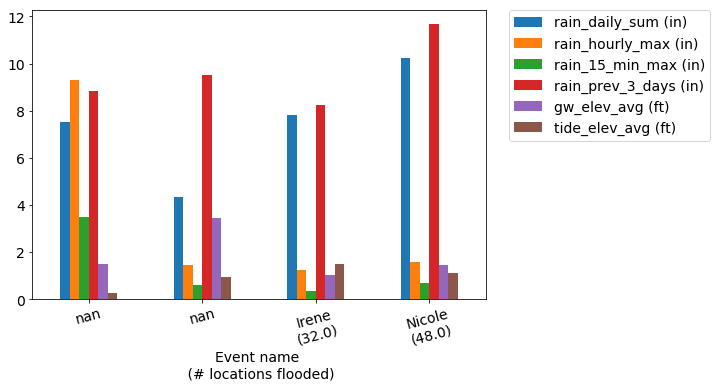

In [15]:
plot_features(high_pc1, df_filt)
df_filt.loc[high_pc1]

In [16]:
rain_df = get_table_for_variable('rainfall')

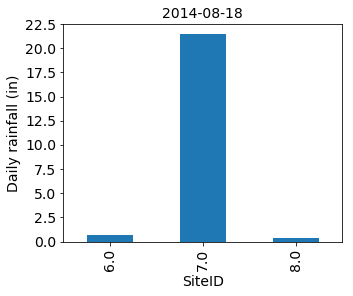

In [17]:
ax2 = rain_df['2014-08-18'].groupby('SiteID').sum()['Value'].plot.bar(figsize=(5,4), fontsize=14, title='2014-08-18')
ax2.set_ylabel('Daily rainfall (in)')
ax2.yaxis.label.set_size(14)
ax2.xaxis.label.set_size(14)
ax2.title.set_size(14)

     index  rain_daily_sum  rain_hourly_max  rain_15_min_max  \
153   2206          1.3500             0.57             0.18   
155   2217          0.7825             0.21             0.10   
491     17          0.9550             0.70             0.36   
492     18          1.6225             0.57             0.18   
152   2202          0.5075             0.20             0.07   
498     27          7.6125             1.43             0.51   

     rain_prev_3_days  gw_elev_avg  tide_elev_avg  num_flooded flooded  \
153      1.350000e+00     6.997553       0.138792          0.0   False   
155      3.872500e+00     6.356799       0.347042          0.0   False   
491      2.305000e+00     4.987574       0.535250          9.0    True   
492      3.117500e+00     4.853232       0.443903          2.0    True   
152      1.825000e+00     4.734056       0.833542          0.0   False   
498     -4.996004e-16     4.794867       1.701608         17.0    True   

             event_name  event_d

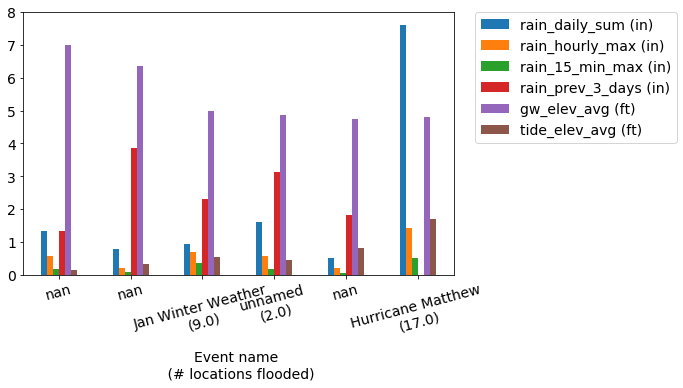

In [18]:
high_pc2 = df_pca.sort_values(1, ascending=False).index[:6]
plot_features(high_pc2, df_filt)
# df_filt.loc[high_pc2, :]